In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau


from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import make_grid
import os

In [28]:
paths=[]
labels=[]
for dirname, _, filenames in os.walk('/kaggle/input/imagenetmini-1000/imagenet-mini/train'):
    for filename in filenames:
        if filename[-4:]=='JPEG':
            paths+=[(os.path.join(dirname, filename))]
            label=dirname.split('/')[-1]
            labels+=[label]
            
tpaths=[]
tlabels=[]
for dirname, _, filenames in os.walk('/kaggle/input/imagenetmini-1000/imagenet-mini/val'):
    for filename in filenames:
        if filename[-4:]=='JPEG':
            tpaths+=[(os.path.join(dirname, filename))]
            label=dirname.split('/')[-1]
            tlabels+=[label]     

In [57]:
list(tdf[tdf['label'] == 0])

['/kaggle/input/imagenetmini-1000/imagenet-mini/val/n01440764/ILSVRC2012_val_00030740.JPEG',
 '/kaggle/input/imagenetmini-1000/imagenet-mini/val/n01440764/ILSVRC2012_val_00046252.JPEG',
 '/kaggle/input/imagenetmini-1000/imagenet-mini/val/n01440764/ILSVRC2012_val_00009111.JPEG']

In [29]:
class_names=sorted(set(labels))
print(len(class_names))
N=list(range(len(class_names)))
normal_mapping=dict(zip(class_names,N)) 
reverse_mapping=dict(zip(N,class_names))    

1000


In [30]:
df=pd.DataFrame(columns=['path','label'])
df['path']=paths
df['label']=labels
df['label']=df['label'].map(normal_mapping)

tdf=pd.DataFrame(columns=['path','label'])
tdf['path']=tpaths
tdf['label']=tlabels
tdf['label']=tdf['label'].map(normal_mapping)

In [2]:
import random

class RandomResize:
    def __init__(self, min_size=256, max_size=512):
        self.min_size = min_size
        self.max_size = max_size

    def __call__(self, img):
        width, height = img.size
        # Randomly choose a new size for the smallest side
        new_size = random.randint(self.min_size, self.max_size)
        
        # Determine the scale factor to resize the image
        if width < height:
            scale_factor = new_size / width
        else:
            scale_factor = new_size / height
        
        # Compute the new dimensions
        new_width = int(width * scale_factor)
        new_height = int(height * scale_factor)
        
        # Resize the image
        return img.resize((new_width, new_height), Image.BILINEAR)

class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        path = self.dataframe.loc[index, 'path']
        label = self.dataframe.loc[index, 'label']
        image = Image.open(path).convert('RGB')

        transform = transforms.Compose([
            
            transforms.RandomHorizontalFlip(),
            RandomResize(min_size=256, max_size=512),
            
            transforms.RandomCrop(224),
            transforms.ToTensor(),
            
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225]),
            
            ])
        image = transform(image)
        return image, label

In [59]:
torch.seed = 42
train_ds=CustomDataset(df)
val_ds=CustomDataset(tdf)
train_loader=DataLoader(train_ds,batch_size=64,shuffle=True)
val_loader=DataLoader(val_ds,batch_size=64)

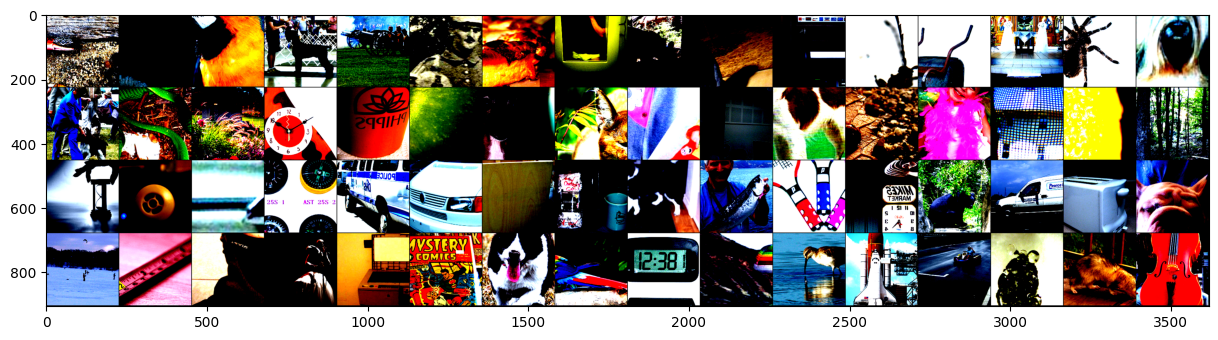

In [7]:
for images, labels in train_loader:
    break

im=make_grid(images,nrow=16)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [8]:
images[0].shape

torch.Size([3, 224, 224])

In [4]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.vgg16 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(25088, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 200),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, x):
        return self.vgg16(x)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG16().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=5e-4, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.1, verbose=True)

In [11]:
for i in range(10):
    total_train_loss = 0
    correct = 0
    total = 0
    for image, label in train_loader:
        image = image.to(device)
        label = label.to(device)
        output = model(image)
        _, predicted = torch.max(output, 1)
        optimizer.zero_grad()
        loss = criterion(output, label)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        total += label.size(0)
        correct += (predicted == label).sum().item()
    
    train_accuracy = 100 * correct / total
    
    total_val_loss = 0
    correct = 0
    total = 0
    
    for image, label in val_loader:
        image = image.to(device)
        label = label.to(device)
        output = model(image)
        loss = criterion(output, label)
        total_val_loss += loss.item()
        total += label.size(0)
        
        _, predicted = torch.max(output, 1)
        correct += (predicted == label).sum().item()
    
    val_accuracy = 100 * correct / total
    scheduler.step(val_accuracy)
    
    print(f"Epoch {i+1}, Loss: {total_train_loss/len(train_loader)}, Accuracy: {train_accuracy}%, Loss: {total_val_loss/len(val_loader)}, Accuracy: {val_accuracy}%")

Epoch 1, Loss: 6.907755440769933, Accuracy: 0.08058713483954526%, Loss: 6.907755382599369, Accuracy: 0.10196278358399184%
Epoch 2, Loss: 6.907755437257321, Accuracy: 0.1180025903007627%, Loss: 6.907755421053979, Accuracy: 0.15294417537598776%
Epoch 3, Loss: 6.90775545394223, Accuracy: 0.12375881421787308%, Loss: 6.9077554364358225, Accuracy: 0.10196278358399184%
Epoch 4, Loss: 6.90775545657669, Accuracy: 0.08634335875665564%, Loss: 6.907755374908447, Accuracy: 0.07647208768799388%
Epoch 5, Loss: 6.907755368761375, Accuracy: 0.0949776946323212%, Loss: 6.907755551799651, Accuracy: 0.17843487127198573%
Epoch 6, Loss: 6.907755439013627, Accuracy: 0.10361203050798676%, Loss: 6.90775546719951, Accuracy: 0.1274534794799898%
Epoch 7, Loss: 6.907755391593357, Accuracy: 0.07770902288099008%, Loss: 6.907755528726885, Accuracy: 0.10196278358399184%
Epoch 8, Loss: 6.90775543989178, Accuracy: 0.10361203050798676%, Loss: 6.907755521035964, Accuracy: 0.1274534794799898%
Epoch 9, Loss: 6.90775542935394

In [11]:
torch.save(small_vgg.state_dict(), 'small_vgg_model.pth')

In [6]:
paths=[]
labels=[]
for dirname, _, filenames in os.walk('/kaggle/input/imagenetmini-1000/imagenet-mini/train'):
    for filename in filenames:
        if filename[-4:]=='JPEG':
            paths+=[(os.path.join(dirname, filename))]
            label=dirname.split('/')[-1]
            labels+=[label]
            
tpaths=[]
tlabels=[]
for dirname, _, filenames in os.walk('/kaggle/input/imagenetmini-1000/imagenet-mini/val'):
    for filename in filenames:
        if filename[-4:]=='JPEG':
            tpaths+=[(os.path.join(dirname, filename))]
            label=dirname.split('/')[-1]
            tlabels+=[label]
            
class_names=sorted(set(labels))
print(len(class_names))
N=list(range(len(class_names)))
normal_mapping=dict(zip(class_names,N)) 
reverse_mapping=dict(zip(N,class_names))    

df=pd.DataFrame(columns=['path','label'])
df['path']=paths
df['label']=labels
df['label']=df['label'].map(normal_mapping)

tdf=pd.DataFrame(columns=['path','label'])
tdf['path']=tpaths
tdf['label']=tlabels
tdf['label']=tdf['label'].map(normal_mapping)

1000


In [7]:
train_ds=CustomDataset(df[(df['label'] >= 0) & (df['label'] <= 199)].reset_index().drop('index', axis=1))
train_loader=DataLoader(train_ds,batch_size=64, shuffle=True)

val_ds=CustomDataset(tdf[(tdf['label'] >= 0) & (tdf['label'] <= 199)].reset_index().drop('index', axis=1))
val_loader=DataLoader(val_ds,batch_size=64)

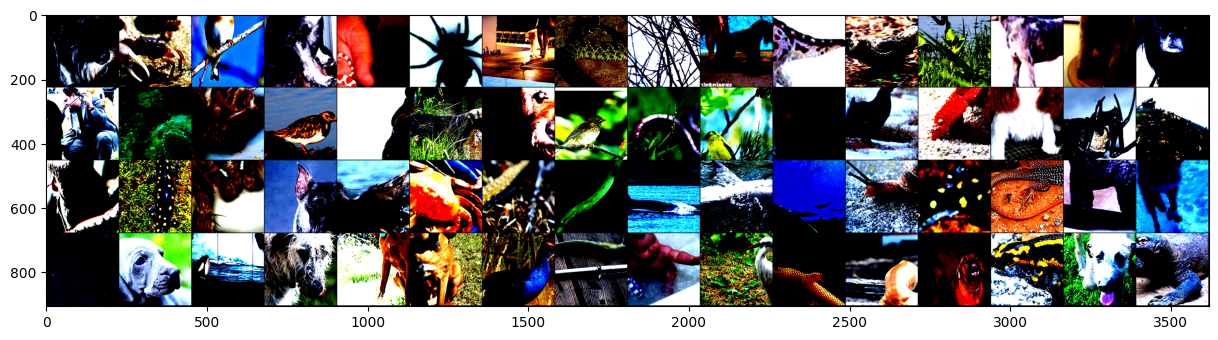

In [5]:
for images, labels in train_loader:
    break

im=make_grid(images,nrow=16)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
small_vgg = VGG16().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(small_vgg.parameters(), lr=0.01, weight_decay=5e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.1, verbose=True)

In [9]:
for i in range(10):
    total_train_loss = 0
    correct = 0
    total = 0
    small_vgg.train()
    for image, label in train_loader:
        image = image.to(device)
        label = label.to(device)
        output = small_vgg(image)
        _, predicted = torch.max(output, 1)
        optimizer.zero_grad()
        loss = criterion(output, label)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        total += label.size(0)
        correct += (predicted == label).sum().item()
    
    train_accuracy = 100 * correct / total
    
    total_val_loss = 0
    correct = 0
    total = 0
    small_vgg.eval()
    with torch.no_grad():
        for image, label in val_loader:
            image = image.to(device)
            label = label.to(device)
            output = small_vgg(image)
            loss = criterion(output, label)
            total_val_loss += loss.item()
            total += label.size(0)

            _, predicted = torch.max(output, 1)
            correct += (predicted == label).sum().item()
    
    val_accuracy = 100 * correct / total
    scheduler.step(val_accuracy)
    
    print(f"Epoch {i+1}, Loss: {total_train_loss/len(train_loader)}, Accuracy: {train_accuracy}%, Loss: {total_val_loss/len(val_loader)}, Accuracy: {val_accuracy}%")

Epoch 1, Loss: 5.298316351572672, Accuracy: 0.525288908899895%, Loss: 5.298318082636053, Accuracy: 0.43103448275862066%
Epoch 2, Loss: 5.2983171735491075, Accuracy: 0.33018159987993395%, Loss: 5.298317995938388, Accuracy: 0.43103448275862066%
Epoch 3, Loss: 5.298316637674968, Accuracy: 0.43523938165991294%, Loss: 5.298317909240723, Accuracy: 0.43103448275862066%
Epoch 4, Loss: 5.298316964649019, Accuracy: 0.5102806543598979%, Loss: 5.298317822543058, Accuracy: 0.43103448275862066%
Epoch 5, Loss: 5.298316805703299, Accuracy: 0.34518985441993094%, Loss: 5.298318169333718, Accuracy: 0.43103448275862066%
Epoch 6, Loss: 5.29831650143578, Accuracy: 0.5102806543598979%, Loss: 5.298318082636053, Accuracy: 0.43103448275862066%
Epoch 00007: reducing learning rate of group 0 to 1.0000e-03.
Epoch 7, Loss: 5.298316624051049, Accuracy: 0.525288908899895%, Loss: 5.298317995938388, Accuracy: 0.43103448275862066%
Epoch 8, Loss: 5.298316396985736, Accuracy: 0.40522287257991896%, Loss: 5.298317995938388,

In [66]:
from torchvision.models import vgg16, VGG16_Weights

vgg16 = vgg16(weights=VGG16_Weights.DEFAULT)
num_classes = 200
vgg16.classifier[6] = nn.Linear(4096, num_classes)
vgg16.to(device)
vgg16.eval()

with torch.no_grad():  
    for image, label in train_loader:
        image = image.to (device)
        label = label.to(device)
        output = vgg16(image)
        _, predicted = torch.max(output, 1)
        correct += (predicted == label).sum().item()
    
    val_accuracy = 100 * correct / total

        
print(val_accuracy)

5.386513157894737


In [3]:
paths=[]
labels=[]
for dirname, _, filenames in os.walk('/kaggle/input/stanford-dogs-dataset/images/Images'):
    for filename in filenames:
        if filename[-3:]=='jpg':
            paths+=[(os.path.join(dirname, filename))]
            label=filename.split('_')[0]
            labels+=[label]
            
class_names=sorted(set(labels))
print(len(class_names))
N=list(range(len(class_names)))
normal_mapping=dict(zip(class_names,N)) 

df=pd.DataFrame(columns=['path','label'])
df['path']=paths
df['label']=labels
df['label']=df['label'].map(normal_mapping)

120


In [20]:
import random

class RandomResize:
    def __init__(self, min_size=256, max_size=512):
        self.min_size = min_size
        self.max_size = max_size

    def __call__(self, img):
        width, height = img.size
        # Randomly choose a new size for the smallest side
        new_size = random.randint(self.min_size, self.max_size)
        
        # Determine the scale factor to resize the image
        if width < height:
            scale_factor = new_size / width
        else:
            scale_factor = new_size / height
        
        # Compute the new dimensions
        new_width = int(width * scale_factor)
        new_height = int(height * scale_factor)
        
        # Resize the image
        return img.resize((new_width, new_height), Image.BILINEAR)

class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        path = self.dataframe.loc[index, 'path']
        label = self.dataframe.loc[index, 'label']
        image = Image.open(path).convert('RGB')

        transform = transforms.Compose([
            
            transforms.RandomHorizontalFlip(),
            RandomResize(min_size=256, max_size=512),
            
            transforms.RandomCrop(224),
            transforms.ToTensor(),
            
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225]),
#              transforms.Resize((256,256)),
    
#                 transforms.RandomRotation(25),
#                 transforms.RandomHorizontalFlip(),

#                 transforms.ToTensor(),
#                 transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
            
            ])
        image = transform(image)
        return image, label

In [4]:
from sklearn.model_selection import train_test_split

torch.manual_seed(42)

X_train, X_test, = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['label'])
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

train_ds = CustomDataset(X_train)

test_ds = CustomDataset(X_test)
train_loader=DataLoader(train_ds,batch_size=64,shuffle=True)
test_loader=DataLoader(test_ds,batch_size=64, shuffle=False)

In [5]:
class dogVGG16(nn.Module):
    def __init__(self):
        super(dogVGG16, self).__init__()
        self.vgg16 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(25088, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 120),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, x):
        return self.vgg16(x)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = dogVGG16().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=5e-4, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.1, verbose=True)

In [ ]:
for i in range(10):
    total_train_loss = 0
    correct = 0
    total = 0
    model.train()
    for image, label in train_loader:
        image = image.to(device)
        label = label.to(device)
        output = model(image)
        _, predicted = torch.max(output, 1)
        optimizer.zero_grad()
        loss = criterion(output, label)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        total += label.size(0)
        correct += (predicted == label).sum().item()
    
    train_accuracy = 100 * correct / total
    
    total_val_loss = 0
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(device)
            label = label.to(device)
            output = model(image)
            loss = criterion(output, label)
            total_val_loss += loss.item()
            total += label.size(0)

            _, predicted = torch.max(output, 1)
            correct += (predicted == label).sum().item()
    
    val_accuracy = 100 * correct / total
    scheduler.step(val_accuracy)
    
    print(f"Epoch {i+1}, Loss: {total_train_loss/len(train_loader)}, Accuracy: {train_accuracy}%, Loss: {total_val_loss/len(test_loader)}, Accuracy: {val_accuracy}%")

Epoch 1, Loss: 3.5106594534807427, Accuracy: 18.513119533527696%, Loss: 2.0886068729253915, Accuracy: 50.242954324586975%
Epoch 2, Loss: 2.2935131843699965, Accuracy: 38.62366375121477%, Loss: 1.7256931946827816, Accuracy: 54.10592808551992%


In [5]:
from torchvision.models import resnet18, ResNet18_Weights

class CustomResnet18(nn.Module):
    def __init__(self, num_classes=120):
        super(CustomResnet18, self).__init__()
        
        # (1) Base model
        self.base_model = resnet18(weights=ResNet18_Weights.DEFAULT)
        
        # (2) Freeze conv block
        for param in self.base_model.parameters():
            param.requires_grad = False
            
        # (3) Modify fc block
        self.base_model.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.base_model.fc.in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        return self.base_model(x)
    
model = CustomResnet18(num_classes=120)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 125MB/s] 


In [19]:
# from torchvision.models import vgg16, VGG16_Weights

# vgg16 = vgg16(weights=VGG16_Weights.DEFAULT)
# num_classes = 120
# vgg16.classifier[6] = nn.Linear(4096, num_classes)
# vgg16.to(device)
# vgg16.eval()
model.eval()
correct = 0
with torch.no_grad():  
    for image, label in test_loader:
        image = image.to (device)
        label = label.to(device)
        output = model(image)
        _, predicted = torch.max(output, 1)
        correct += (predicted == label).sum().item()
    
    val_accuracy = 100 * correct / total

        
print(val_accuracy)

62.17201166180758


In [47]:
total

6792

In [42]:
predicted

tensor([ 8, 73, 39, 84, 65, 77,  9, 19], device='cuda:0')

In [49]:
correct

0.015901060070671377

In [41]:
(predicted == label).sum().item()

0

In [1]:
torch.save(model.state_dict(), 'dog_vgg_model.pth')